In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import re
from glob import glob
import subprocess
from matplotlib import pyplot as plt

In [3]:
def load_fastqc_txt(fastqc_filename):
    fastqc_out = {}
    module_name = ""
    module_output= []
    with open(fastqc_filename) as fastqc_fh:
        for line in fastqc_fh:
            line = line.rstrip("\n")
            if line.startswith(">>END_MODULE"):
                fastqc_out[module_name] = module_output
                module_output = []
            elif line.startswith(">>"):
                module_name = line.lstrip(">").split("\t")[0]
            else:
                module_output.append(line)
    return fastqc_out

In [29]:
def parse_fastq(fastq_file):
    stats = {}
    cat_zcat = "zcat" if fastq_file.endswith(".gz") else "cat"
    read_lengths = subprocess.Popen(cat_zcat+' '+fastq_file+' | sed -n "2~4p" | awk "{print length($1)}" ',shell=True,stdout=subprocess.PIPE).stdout
    read_lengths = Counter(int(x) for x in read_lengths)
    stats["filename"] = fastq_file
    stats["n_bases"] = sum( k*read_lengths[k] for k in read_lengths )
    stats["n_reads"] = sum( read_lengths[k] for k in read_lengths  )
    stats["read_len_freqs"] = read_lengths
    return stats

In [82]:
def plot_read_len_dist(stats_obj_list):
    if len(stats_obj_list) == 3:
        fig1, fig_axes = plt.subplots(nrows=3,ncols=1)
    else:
        fig1, fig_axes = plt.subplots(nrows=2,ncols=2)
        fig_axes = itertools.chain(*fig_axes)
    
    for ax,stats_obj in zip(fig_axes,stats_obj_list):
        #Calculate histogram range
        hist_range = range(min(stats_obj["read_len_freqs"]), max(stats_obj["read_len_freqs"])+1 )
        #Get list of freqs for all read lengths
        hist_values = map(lambda k: stats_obj["read_len_freqs"][k] if k in stats_obj["read_len_freqs"] else 0  , hist_range)

        pos = np.arange(len(hist_range))
        width = 1     # gives histogram aspect to the bar diagram

        ax.text(0.05,0.95,"# reads: {}".format(stats_obj["n_reads"]),transform=ax.transAxes)
        ax.text(0.05,0.9,"# bases: {}".format(stats_obj["n_bases"]),transform=ax.transAxes)
        ax.text(0.05,0.85,"Avg read len: {}".format(stats_obj["n_bases"]/stats_obj["n_reads"]),transform=ax.transAxes)
        
        ax.set_title( stats_obj["filename"] )
        ax.set_xticks(pos + (width / 2))
        #Print every 10 axis labels
        ax.set_xticklabels( [x if (idx % 10 == 0) or (idx+1 == len(hist_range)) else "" for idx, x in enumerate(hist_range)] , rotation = 90 )

        ax.bar(pos, hist_values, width, color='r')
    
    plt.show()

# 1. Raw Data

In [58]:
raw_r1_stats= parse_fastq(glob("reads/*.fastq.gz")[0])

In [66]:
print "Number of (paired-end) reads: {} ".format(raw_r1_stats["n_reads"])
print "Number of bases: 2 * {} = {} ".format(raw_r1_stats["n_bases"],2*raw_r1_stats["n_bases"])
print "Read Length: {} ".format(raw_r1_stats["read_len_freqs"].items()[0][0])

Number of (paired-end) reads: 3177981 
Number of bases: 2 * 956572281 = 1913144562 
Read Length: 301 


# 2. Quality Filtering

In [64]:
qf_fastq_files = sorted(glob("2_qf/*.fq.gz"))
print qf_fastq_files
qf_stats_list = map(parse_fastq,qf_fastq_files)

['2_qf/test_qf_R1.fq.gz', '2_qf/test_qf_R2.fq.gz', '2_qf/test_qf_merged.fq.gz', '2_qf/test_qf_single.fq.gz']


In [71]:
qf_total_reads= qf_stats_list[0]["n_reads"]+qf_stats_list[2]["n_reads"]+qf_stats_list[3]["n_reads"]
qf_total_bases = sum( x["n_bases"] for x in qf_stats_list )
print "Reads after quality filtering: {} pe + {} merged pe + {} single = {}".format(qf_stats_list[0]["n_reads"],
                                                         qf_stats_list[2]["n_reads"],
                                                         qf_stats_list[3]["n_reads"],
                                                         qf_total_reads)
print "Num of bases remaining after quality filtering: {}".format(qf_total_bases)
print "Pct of bases remaining after quality filtering: {}%".format(100.0 * qf_total_bases / (2*raw_r1_stats["n_bases"]) )

Reads after quality filtering: 1983641 + 1095333 + 19558 = 3098532
Num of bases remaining after quality filtering: 983077043
Pct of bases remaining after quality filtering: 51.3854029918%


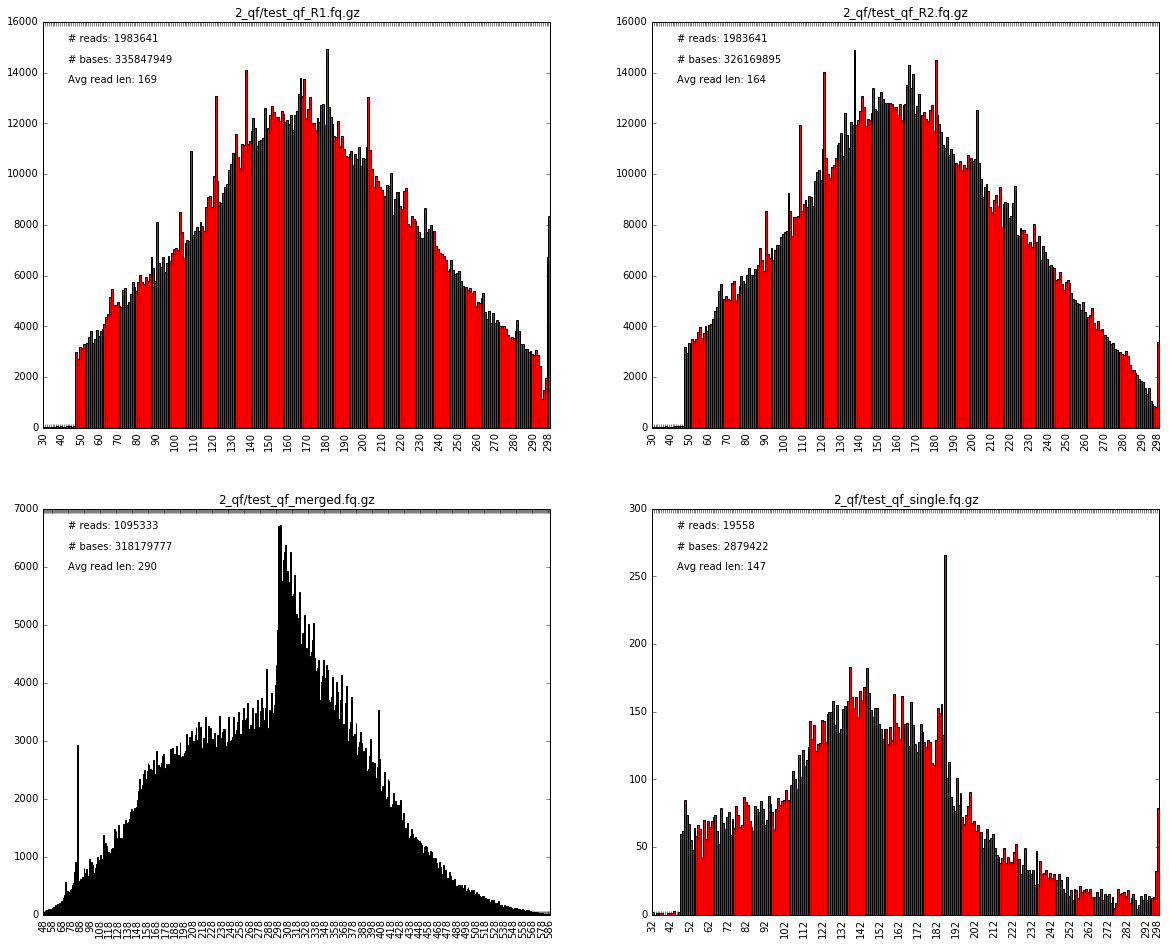

In [83]:
import pylab
pylab.rcParams['figure.figsize'] = (20.0, 16.0)
plot_read_len_dist( qf_stats_list )

# 3. Host Filtering

In [72]:
hf_fastq_files = sorted(glob("3_hostfiltering/*.fq"))
print hf_fastq_files
hf_stats_list = map(parse_fastq,hf_fastq_files)

['3_hostfiltering/test_qf_hf_merged.fq', '3_hostfiltering/test_qf_hf_pe.fq', '3_hostfiltering/test_qf_hf_single.fq']


In [86]:
hf_total_reads= (hf_stats_list[0]["n_reads"]) + ( hf_stats_list[1]["n_reads"]/2) + hf_stats_list[2]["n_reads"]
hf_total_bases = sum( x["n_bases"] for x in hf_stats_list )
print "Number of effective reads: {} pe + {} merged pe + {} single = {}".format(hf_stats_list[1]["n_reads"],
                                                         hf_stats_list[0]["n_reads"],
                                                         hf_stats_list[2]["n_reads"],
                                                         hf_total_reads)
print "Num of effective bases: {}".format(hf_total_bases)
print "Pct of bases remaining after host filtering: {}%".format(100.0 * hf_total_bases / (2*raw_r1_stats["n_bases"]) )

Number of effective reads: 170756 pe + 19167 merged pe + 549 single = 105094
Num of effective bases: 35798839
Pct of bases remaining after host filtering: 1.87120407475%


In [79]:
#Human pct defined as proportion of bases discarded from qf'ed bases
print "Pct of human in data: {}%".format(100.0 * (qf_total_bases - hf_total_bases) / qf_total_bases )

Pct of human in data: 96.3584909998%


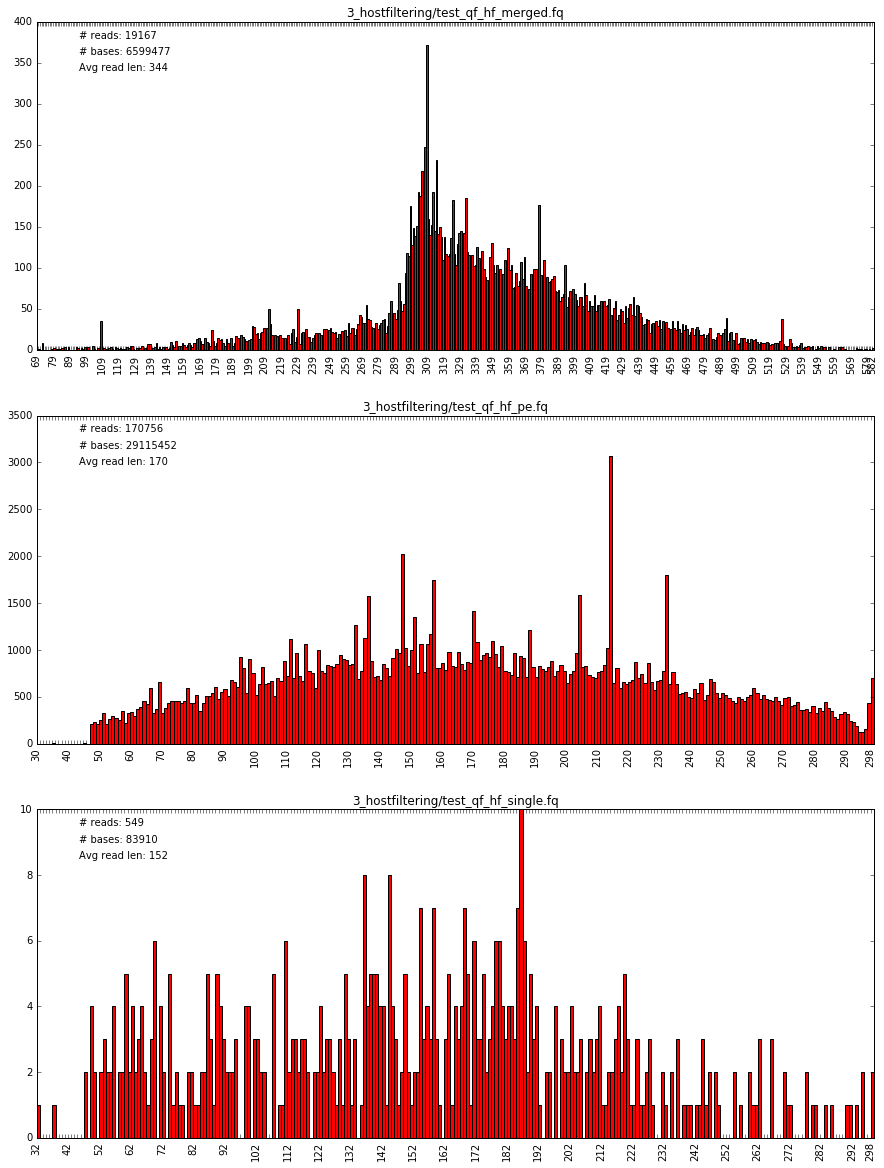

In [84]:
pylab.rcParams['figure.figsize'] = (15, 20)
plot_read_len_dist( hf_stats_list )